In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Multivariate Gaussian function

$f(\mathbf{x}, \boldsymbol{\mu}, \Sigma) = (2\pi)^{-M/2}|\Sigma|^{-1/2}~e^{\frac{-1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})}$


In [2]:
def gaussian(x, mu, cov):
    # x and mu should be vectors in numpy, shape=(2,)
    # cov should be a matrix in numpy, shape=(2,2)
    M = 2
    scale = (2*np.pi)**(-M/2)*np.linalg.det(cov)**(-1/2)
    return scale*np.exp(-(1/2)*(x-mu).T @ np.linalg.inv(cov) @ (x-mu))

## Plot Gaussian contours function

In [3]:
def plot_gaussian(mu, cov, x1_min=-10, x1_max=10, x2_min=-10, x2_max=10, color=None):
    # x and mu should be vectors in numpy, shape=(2,)
    # cov should be a matrix in numpy, shape=(2,2)

    x1_values = np.linspace(x1_min, x1_max, 101)
    x2_values = np.linspace(x2_min, x2_max, 101)

    x1_grid, x2_grid = np.meshgrid(x1_values,x2_values)

    M,N = x1_grid.shape
    y_grid = np.zeros((M,N))

    x = np.zeros((2,))

    for i in range(M):
        for j in range(N):
            x[0] = x1_grid[i,j]
            x[1] = x2_grid[i,j]

            y_grid[i,j] = gaussian(x, mu, cov)

    plt.contour(x1_grid, x2_grid, y_grid, colors=color)

## Load data
Note: The code assumes that the data file is in the same folder as the jupyter notebook. In Google colab, you can upload the file directly into the workspace by in the Files tab on the left.

In [4]:
X = np.loadtxt("./gmm_data.csv", delimiter=",")
print(X.shape)

(2000, 2)


## Gaussian mixture model

### Hyperparameters

In [5]:
# N: number of observations
# D: number of features of each observation
# K: number of classes
# T: number of iterations
N, D = X.shape
K = 4
T = 1
# T = 30
# T = 100

### Parameter initialization

In [6]:
# pi_0: shape=(K,), pi_0[k] = 1 / K
# mu_0: shape=(K, D), mu_0[k] = np.full(D, k+1)
# sigma_0: shape=(K, D, D), sigma_0[k] = np.eye(D)

pi_0 = np.full(K, 1 / K)
mu_0 = np.tile(np.arange(1, K+1), (D, 1)).T
sigma_0 = np.tile(np.eye(D), (K, 1, 1))

### EM update

In [7]:
# pi: shape=(K,), pi[k] = p(z_k^(i) = 1)
# mu: shape=(K, D), mu[k] is the centroid of cluster k
# sigma: shape=(K, D, D), sigma[k] is the covariance matrix of cluster k
# eta: shape=(K, N), eta[k, i] = p(z_k^(i) = 2 | x^(i), mu_k^(t), sigma_k^(t))
# n: shape=(K,), n[k] = N_k^(t)

pi = pi_0.copy()
mu = mu_0.copy()
sigma = sigma_0.copy()
eta = np.zeros((K, N))
n = np.zeros(K)

for _ in range(T):
    # Expectation
    for i, x_i in enumerate(X):
        for k, (pi_k, mu_k, sigma_k) in enumerate(zip(pi, mu, sigma)):
            eta[k, i] = pi_k * gaussian(x_i, mu_k, sigma_k)
    eta = eta / np.einsum('ki->i', eta)

    # Maximization
    n = np.einsum('ki->k', eta)
    pi = n / N
    mu = np.einsum('ki,id->kd', eta, X) / n[:, None]
    # Compute centered X: Xc = X - mu
    Xc = X[:, None, :] - mu[None, :, :]
    sigma = np.einsum('ki,ikd,ike->kde', eta, Xc, Xc) / n[:, None, None]

## Plot data with initial Gaussian contours

Text(0.5, 1.0, 'Iteration 0')

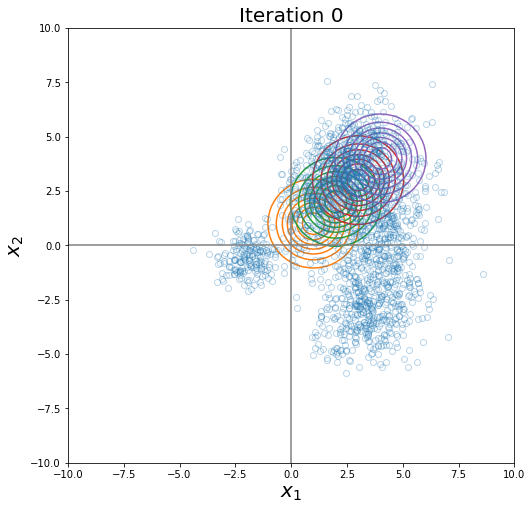

In [8]:
# Square figure size
plt.figure(figsize=(8,8))

# Plot points
plt.plot(X[:,0], X[:,1], 'o', markerfacecolor="None", alpha=0.3)

# Plot K Gaussians
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for k in range(K):
    plot_gaussian(mu_0[k], sigma_0[k], color=colors[k])

# Axes
plt.gca().axhline(y=0, color='gray')
plt.gca().axvline(x=0, color='gray')

# Labels
plt.xlabel("$x_1$", fontsize=20)
plt.ylabel("$x_2$", fontsize=20)
plt.title("Iteration 0", fontsize=20)

## Plot data with updated Gaussian contours

Text(0.5, 1.0, 'Iteration 1')

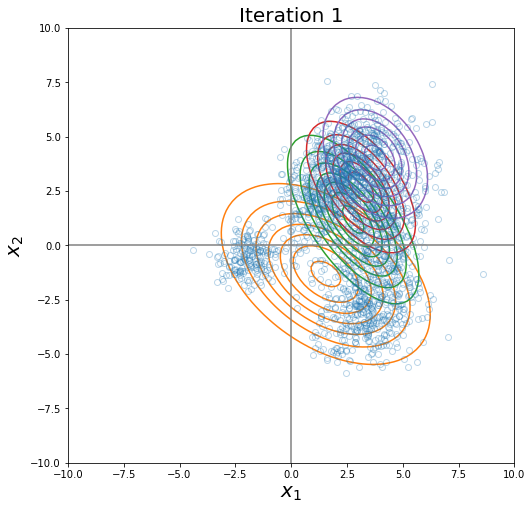

In [9]:
# Square figure size
plt.figure(figsize=(8,8))

# Plot points
plt.plot(X[:,0], X[:,1], 'o', markerfacecolor="None", alpha=0.3)

# Plot K Gaussians
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for k in range(K):
    plot_gaussian(mu[k], sigma[k], color=colors[k])

# Axes
plt.gca().axhline(y=0, color='gray')
plt.gca().axvline(x=0, color='gray')

# Labels
plt.xlabel("$x_1$", fontsize=20)
plt.ylabel("$x_2$", fontsize=20)
plt.title(f"Iteration {T}", fontsize=20)